In [1]:
import numpy  as np
import time
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags

def heat(nx, ny, u0, f, L=1, H=1, max_iter=10000, epsilon=1e-7):
    """ Fonction simulant l'équation de la chaleur stationnaire 2D sur un maillage cartésien uniforme par différences finies
    avec des conditions aux limites de type Dirichlet homogène. Arguments :
        - nx : nombre de mailles selon x
        - ny : nombre de mailles selon y
        - u0 : solution initiale (scalaire)
        - f : terme source (fonction prenant 2 scalaires (x, y) en entrée pour retourner un scalaire f(x, y))
        - L : longueur du domaine (= 1 par défaut)
        - H : hauteur du domaine (= 1 par défaut)
        - max_iter : nombre maximal d'itérations pour le gradient conjugué (= 10000 par défaut)
        - epsilon : seuil d'erreur minimal pour le gradient conjugué (= 1e-7 par défaut) """

       # Construction du maillage : liste P des points P(i,j) = (x(i), y(j)) 
    # du maillage indexés par k = i - 1 + nx * (j - 1)
    N = nx * ny
    dx = L / (nx+1)
    dy = H / (ny+1)
    P = np.array([[[i * dx, j * dy] for i in range(1, nx + 1)] for j in range(1, ny + 1)]) 
    P = P.reshape(N, 2)

    # Construction du système linéaire Au = b
    
    N = nx * ny
    alpha = 2 * (1 / dx**2 + 1 / dy**2) * np.ones(N) # Diagonale de A
    beta = - np.ones(N - 1) / dx ** 2 # Diagonales décalées de 1 indice
    beta[nx - 1::nx] = 0 # Brisures de la diagonale
    gamma = - np.ones(N - nx) / dy ** 2 # Diagonale décalée de nx indices
    k = [gamma, beta, alpha, beta, gamma]
    offset = [-nx, -1, 0, 1, nx]
    A = diags(k, offset).toarray() # Matrice A
    b = np.array([f(P[k, 0], P[k, 1]) for k in range(N)]) # Second membre b

    # Résolution du système linéaire
    
    u = u0 * np.ones(N) 
    rk = b - np.dot(A,u)
    p = rk
    k = 0
    kmax = max_iter

    while np.linalg.norm(rk) > epsilon and k < kmax:
        z = np.dot(A, p)
        alpha = np.dot(rk,p) / np.dot(z, p)
        u = u - alpha * p
        rkp1 = rk - alpha * z
        gamma =  np.dot(rkp1,rkp1) / np.dot(rk,rk)
        p = rkp1 + gamma * p
        rk = rkp1
        k += 1
        
    print("Nombre d'itérations du gradient conjugué: ", k)
    print("Résidu du gradient conjugué: ", np.linalg.norm(rk))

    u2D = u.reshape(Nx, Ny)
    u = np.zeros((Nx+2, Ny+2))
    u[1:-1, 1:-1] = u2D

    
    return u, A, b, u2D

Nombre d'itérations du gradient conjugué:  300
Résidu du gradient conjugué:  9.429228780280006e-08


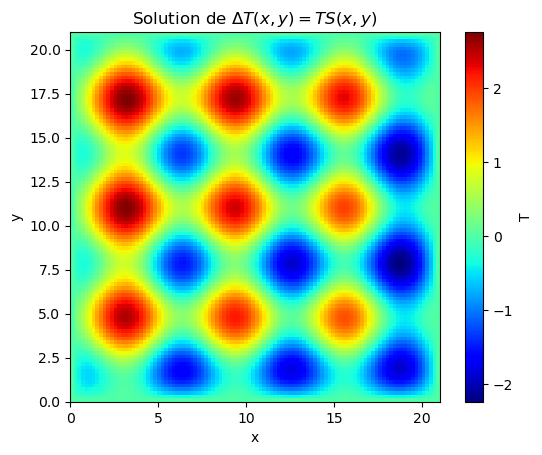

In [2]:
# Définition du terme source

def TS(x,y):
    
    return np.cos(x) + np.sin(y)

# Définition des paramètres

Nx = 100
Ny = 100
H = 21
L = 21

# Résolution du problème

T = heat(Nx, Ny, 0, TS, H=H, L=L)[0]

# Affichage du résultat

plt.imshow(T, origin='lower', cmap='jet', extent=[0, L, 0, H])
cbar = plt.colorbar() 
cbar.set_label('T')

plt.xlabel('x')  # Légende de l'axe X
plt.ylabel('y')  # Légende de l'axe Y
plt.title(r'Solution de $\Delta T(x,y) = TS(x,y)$')  # Titre du graphique

plt.show()

In [5]:
from tqdm.notebook import tqdm

# Définition des paramètres

# Second membre
n = 2 # dégré du polynôme interpolant f
Nd = int((n+1) * (n+2) / 2)
# Discrétisation
Nx = 100
Ny = 100
# Dimensions
H = 7
L = 7
# Maillage : taille et points
dx = L / (Nx+1)
dy = H / (Ny+1)
P = np.array([[[i * dx, j * dy] for i in range(1, Nx + 1)] for j in range(1, Ny + 1)]) 
P = P.reshape(Nx*Ny, 2)
# Nombre de points de mesures de la température exacte < Nx*Ny
N = 5000 

# Matice second membre polynomial
M = []
for k in range(n+1):
    for i in range(k+1):
        # [x^0y^0, x^0y^1, x^1y^0, x^0y^2, x^1y^1, x^2y^0, ...]
        M.append((P[:,0] ** i) * (P[:,1] ** (k - i)))
M = np.array(M)


# Définition du terme source
def TS(x,y):
    return 2 * (x**2 + y**2 - (L*x + H*y)) / (L*H)


# Résolution du problème (solution exacte)
Uex, A, bex, Tex = heat(Nx, Ny, 0, TS, H=H, L=L, epsilon=1e-7)

#Définition des Variables X, T, Lambda, B pour l'algo d'Uzawa
B = np.concatenate([A, -M]).T
X = np.zeros(Nx*Ny + Nd)
Lambda = np.zeros(Nx*Ny)
T = Tex.flatten()
Tf = np.concatenate([T, np.zeros(Nd)])

# Définition de Gamma et son inverse Gm1
epsilon = 1e-7
Gamma = np.ones(Nx*Ny+Nd) * epsilon
# Indices des points non nuls sur la diagonale
indices = np.linspace(0, Nx*Ny - 1, N, dtype=int)
# Placement des 1 sur la diagonale à ces indices
Gamma[indices] += 1
Gm1 = 1 / Gamma

max_iter=1000
nbiter = 1
nu = 0.1
errmax = []
mse = []


for k in range(max_iter):
    #X =  Gm1 * np.dot(B.T,Lambda) + Gamma * Tf
    gradient = Gm1 * np.dot(B.T,Lambda) + Gamma * Tf

    X = X - nu * gradient
    u = X[:Nx*Ny]
    F = X[Nx*Ny:]
    b = np.dot(M.T,F)
    rk = np.linalg.norm(np.dot(A,u) - b)
    errmax.append(np.abs(u - T).max() / np.abs(T).max())
    mse.append(np.mean((u - T) ** 2) / np.mean(T ** 2))
    #nu = errmax[-1]/10

Nombre d'itérations du gradient conjugué:  178
Résidu du gradient conjugué:  8.945155765688843e-08


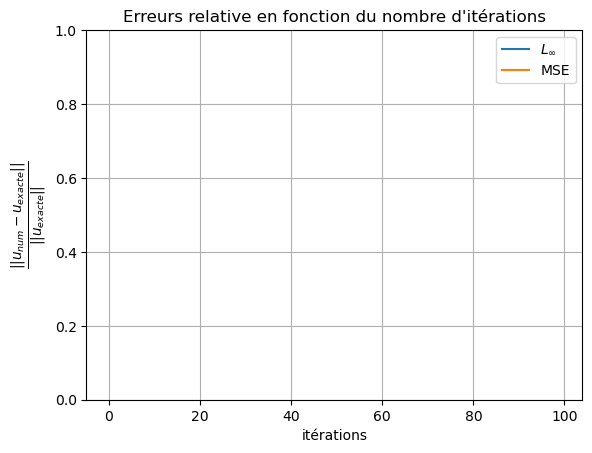

Text(0.5, 1.0, 'Différence Absolue')

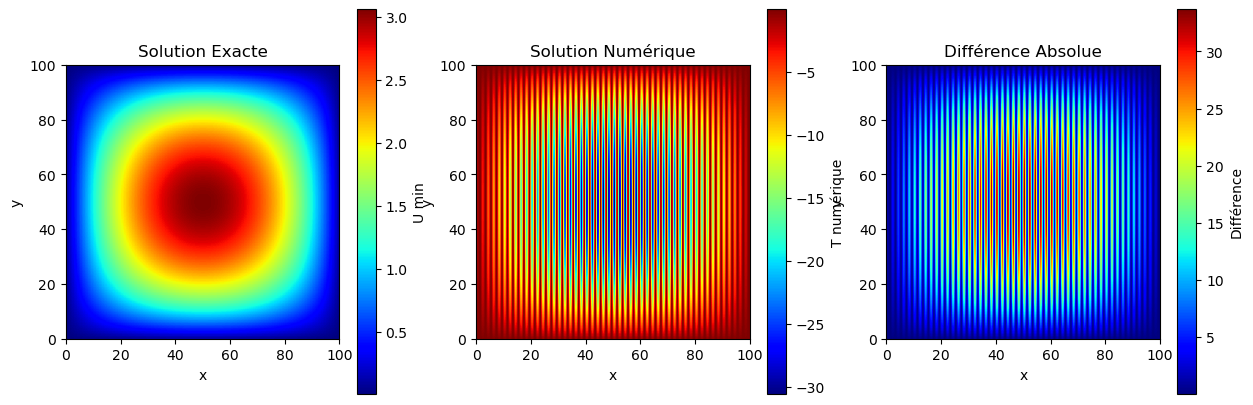

In [4]:
errmax = np.array(errmax)
mse = np.array(mse)

u2D = u.reshape(Nx, Ny)
T2D = T.reshape(Nx, Ny)

# Calcul de la différence
diff = np.abs(u2D - T2D)

plt.plot(np.arange(0, mse.shape[0], 1), errmax, label=r'$L_{\infty}$')
plt.plot(np.arange(0, mse.shape[0], 1), mse, label=r'MSE')
plt.ylim(0, 1)
plt.grid()
plt.xlabel('itérations')
plt.ylabel(r'$\frac{||u_{num} - u_{exacte} ||}{||u_{exacte}||}$', fontsize=14, fontweight='bold')
plt.title("Erreurs relative en fonction du nombre d'itérations")
plt.legend(loc='best')
plt.show()

# Ajustement de la taille de la figure pour une meilleure visibilité des barres de couleur
plt.figure(figsize=(15, 5)) # Figure plus large

# Affichage de la solution numérique
plt.subplot(1, 3, 2)
plt.imshow(u2D, origin='lower', cmap='jet', extent=[0, len(u2D[0]), 0, len(u2D)])
plt.colorbar(label='T numérique')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Numérique')

# Affichage de la solution du gradient projeté
plt.subplot(1, 3, 1)
plt.imshow(T2D, origin='lower', cmap='jet', extent=[0, len(T2D[0]), 0, len(T2D)])
plt.colorbar(label='U min')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Exacte')

# Affichage de la différence
plt.subplot(1, 3, 3)
plt.imshow(diff, origin='lower', cmap='jet', extent=[0, len(diff[0]), 0, len(diff)])
plt.colorbar(label='Différence')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Différence Absolue')

In [76]:
from tqdm.notebook import tqdm
from tqdm.auto import trange

# Définition des paramètres

# Second membre
n = 2 # dégré du polynôme interpolant f
Nd = int((n+1) * (n+2) / 2)
# Discrétisation
Nx = 100
Ny = 100
# Dimensions
H = 7
L = 7
# Maillage : taille et points
dx = L / (Nx+1)
dy = H / (Ny+1)
P = np.array([[[i * dx, j * dy] for i in range(1, Nx + 1)] for j in range(1, Ny + 1)]) 
P = P.reshape(Nx*Ny, 2)
# Nombre de points de mesures de la température exacte < Nx*Ny
N = 5000

# Matice second membre polynomial
M = []
for k in range(n+1):
    for i in range(k+1):
        # [x^0y^0, x^0y^1, x^1y^0, x^0y^2, x^1y^1, x^2y^0, ...]
        M.append((P[:,0] ** i) * (P[:,1] ** (k - i)))
M = np.array(M)

print("len(M):", len(M))


# Définition du terme source
def TS(x,y):
    return 2 * (x**2 + y**2 - (L*x + H*y)) / (L*H)


# Résolution du problème (solution exacte)
Uex, A, bex, Tex = heat(Nx, Ny, 0, TS, H=H, L=L, epsilon=1e-7)

#Définition des Variables X, T, Lambda, B pour l'algo d'Uzawa
#B = np.block([[A,-M]])
#BBTinv = np.linalg.inv(B@B.T)
T = Tex.flatten()
Tf = np.concatenate([T, np.zeros(Nd)])
B = np.concatenate([A, -M])
print("len(B):", len(B))
print("len(B[0]):", len(B[0]))
#BBTinv = np.concatenate([A, -M]).T
BBTinv = np.linalg.inv(B.T@B)
#BBTinv = np.linalg.inv(B@B.T)
print("len(BBTinv):", len(BBTinv))
print("len(BBTinv[0]):", len(BBTinv[0]))
Ainv = np.linalg.inv(A)

# Définition de Gamma et son inverse Gm1
epsilon = 1e-7
Gamma = np.ones(Nx*Ny+Nd) * epsilon

indices = np.linspace(0, Nx*Ny - 1, N, dtype=int)
# Placement des 1 sur la diagonale à ces indices
Gamma[indices] += 1

errmax = []
mse = []


def descente_gradient(fonction_gradient, x0, pas_descente=1.e-3, nb_iterations_max=1_000, seuil=1.e-3, subbar=False):
  global M, Tf
  historique = np.zeros(nb_iterations_max)
  # état initial
  x = x0
  # pour de jolies barres de chargement, même pour Uzawa
  if (subbar):
    position=1
    leave=False
  else:
    position=0
    leave=True
  # descente
  for nb_iter in trange(1, nb_iterations_max, desc="descente de gradient", position=position, leave=leave):
    # calcul du gradient
    G = fonction_gradient(x)
    normG = np.linalg.norm(G)
    historique[nb_iter] = normG
    if (normG < seuil):
      break
    # descente à pas constant
    x -= pas_descente*G/normG
    errmax.append(np.abs(x - Tf).max() / np.abs(Tf).max())
    mse.append(np.mean((x - Tf) ** 2) / np.mean(Tf ** 2))

  return x

def gradient_projete(Xvec):
  global Gamma, Ainv, M, T, B, BBTinv
  U = Xvec
  #alpha = Xvec[N:]
  #print("len(Gamma)", len(Gamma))
  gradI_x = Gamma * (U  - Tf)
  #print("len(gradI_x)", len(gradI_x))
  #gradI_x = np.concatenate([gradI_u, gradI_u@Ainv@M])
  Lambda = BBTinv @ ( B.T @ gradI_x )
  #print("len(Lambda)", len(Lambda))
  #G = gradI_x - np.dot(B,Lambda)
  G = gradI_x - B @ Lambda
  return G


Xvec0 = np.zeros(Nx*Ny + Nd)


Xvec = descente_gradient(gradient_projete, Xvec0, pas_descente=1.e-2)
u = Xvec[:Nx*Ny]

len(M): 6
Nombre d'itérations du gradient conjugué:  178
Résidu du gradient conjugué:  8.945155765688843e-08
len(B): 10006
len(B[0]): 10000
len(BBTinv): 10000
len(BBTinv[0]): 10000


descente de gradient:   0%|          | 0/999 [00:00<?, ?it/s]

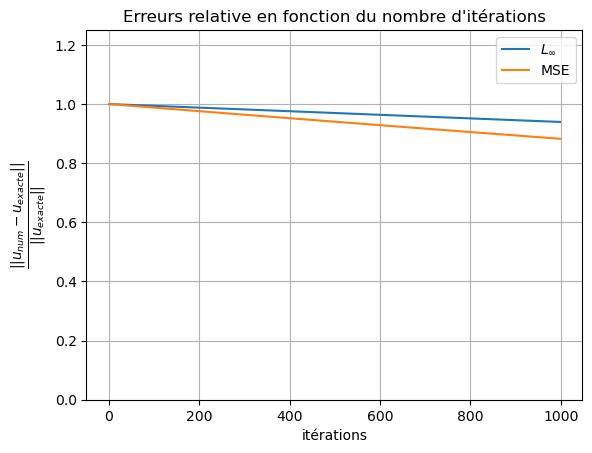

Text(0.5, 1.0, 'Différence Absolue')

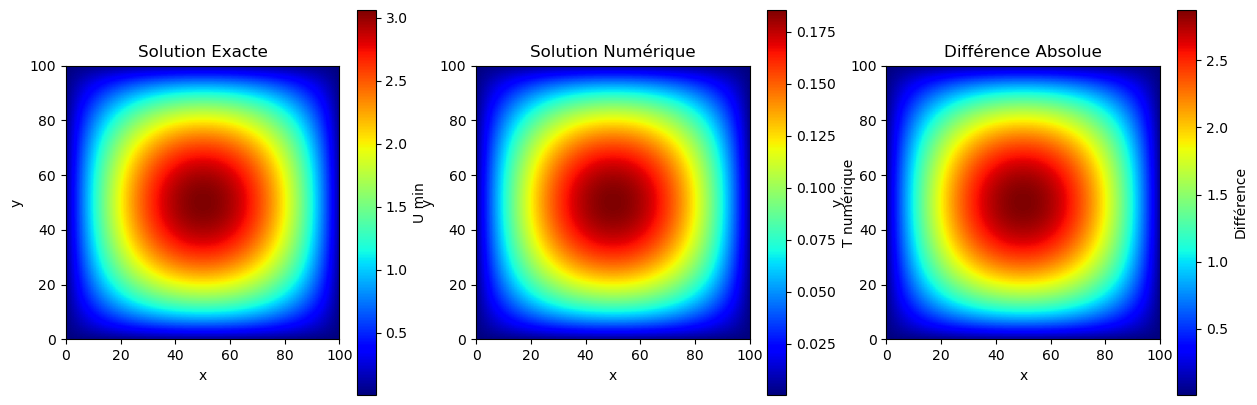

In [80]:
errmax = np.array(errmax)
mse = np.array(mse)

u2D = u.reshape(Nx, Ny)
T2D = T.reshape(Nx, Ny)

# Calcul de la différence
diff = np.abs(u2D - T2D)

plt.plot(np.arange(0, mse.shape[0], 1), errmax, label=r'$L_{\infty}$')
plt.plot(np.arange(0, mse.shape[0], 1), mse, label=r'MSE')
plt.ylim(0, 1.25)
plt.grid()
plt.xlabel('itérations')
plt.ylabel(r'$\frac{||u_{num} - u_{exacte} ||}{||u_{exacte}||}$', fontsize=14, fontweight='bold')
plt.title("Erreurs relative en fonction du nombre d'itérations")
plt.legend(loc='best')
plt.show()

# Ajustement de la taille de la figure pour une meilleure visibilité des barres de couleur
plt.figure(figsize=(15, 5)) # Figure plus large

# Affichage de la solution numérique
plt.subplot(1, 3, 2)
plt.imshow(u2D, origin='lower', cmap='jet', extent=[0, len(u2D[0]), 0, len(u2D)])
plt.colorbar(label='T numérique')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Numérique')

# Affichage de la solution du gradient projeté
plt.subplot(1, 3, 1)
plt.imshow(T2D, origin='lower', cmap='jet', extent=[0, len(T2D[0]), 0, len(T2D)])
plt.colorbar(label='U min')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Solution Exacte')

# Affichage de la différence
plt.subplot(1, 3, 3)
plt.imshow(diff, origin='lower', cmap='jet', extent=[0, len(diff[0]), 0, len(diff)])
plt.colorbar(label='Différence')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Différence Absolue')